#  Garfield: topic extraction and retrieval system

    Project and Project Work in Text Mining, Data Mining and Big Data Analytics
    Author: Enrico Benedetti
    Email: enrico.benedetti5 [at] studio.unibo.it
    GitHub: https://github.com/EnricoBenedetti

## Download and first look at the Garfield Dataset

In [ ]:
#!pip install --upgrade numpy
#!pip install --upgrade gensim
!pip install gensim==4.1.0
!pip install kneed
!pip install sentence_transformers
#!pip install torch==1.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 35.1 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.6 MB/s eta 0:00:00
  Created wheel for sentence_t

In [ ]:
import urllib.request
# download the raw data online
urllib.request.urlretrieve("http://john.ccac.rwth-aachen.de:8000/ftp/dilbert/garfield.txt", "garfield.txt")

('garfield.txt', <http.client.HTTPMessage at 0x7efc33f36be0>)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
#plt.rcParams["figure.figsize"] = (25, 10)
#plt.rcParams['figure.dpi'] = 450
#plt.rcParams['axes.xmargin'] = 0
#plt.rcParams['axes.ymargin'] = 0

In [ ]:
# read text file into pandas DataFrame
df = pd.read_csv("garfield.txt", sep=" -- ", encoding = 'latin1', names=["stripID", "text"], engine='python')

In [ ]:
df = df.dropna().copy()

In [ ]:
df

,stripID,text
0,ga780619,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist..."
1,ga780620,"Happy birthday, Garfield. I have a surprise fo..."
2,ga780621,A MOUSE! GET IT! - Garfield! You didn't even t...
3,ga780622,"I'm putting you on a diet, Garfield...here's y..."
4,ga780623,- Ahhhhh... - Happiness is a warm television set.
...,...,...
17133,ga230201,Garfield... - Pizza is not a healthy breakfast...
17134,ga230202,What's the key to a successful diet? - Portion...
17135,ga230203,"Jon, you've been sitting there a long time. - ..."
17136,ga230204,Look! Irma's Diner just expanded their menu. -...


## Dataframe setup

### Adding date information to dataframe

Using the format specifications of `datetime` and `pandas`, a timestamp is extracted from the `stripID` column and added as a `Date` column.

The code below tries to avoid throwing away some strips (~10) that have parsing errors in the `StripID` column.

In [ ]:
preformat_dates = df['stripID'].to_numpy()
formatted_dates = preformat_dates.copy()
for index, stripID in enumerate(preformat_dates):
  try:
    formatted_dates[index] = pd.to_datetime(stripID, format="ga%y%m%d")
  except: 
    # fix abnormal month using the same as the previous strip (they are temporally ordered)
    previous_date_month = formatted_dates[index-1].strftime('%m')
    # avoids mistakes in the first two characters (eg. gs instead of ga)
    stripID = 'ga' + stripID[2:4] + previous_date_month + stripID[-2:]
    formatted_dates[index] = pd.to_datetime(stripID, format="ga%y%m%d")
    print(f'Fixed string with error {preformat_dates[index]} to correct timestamp {formatted_dates[index]}')
    preformat_dates[index] = stripID

# add the date column and also the correct stripID
df['Date'] = formatted_dates
df['stripID'] = preformat_dates

Fixed string with error ga929927 to correct timestamp 1992-09-27 00:00:00
Fixed string with error ga982023 to correct timestamp 1998-10-23 00:00:00
Fixed string with error ga130015 to correct timestamp 2013-01-15 00:00:00
Fixed string with error ga131302 to correct timestamp 2013-12-02 00:00:00
Fixed string with error ga131323 to correct timestamp 2013-12-23 00:00:00
Fixed string with error ga159829 to correct timestamp 2015-08-29 00:00:00
Fixed string with error ga160017 to correct timestamp 2016-01-17 00:00:00
Fixed string with error gs161008 to correct timestamp 2016-10-08 00:00:00
Fixed string with error ga170017 to correct timestamp 2017-01-17 00:00:00
Fixed string with error ga182130 to correct timestamp 2018-12-30 00:00:00
Fixed string with error ga192224 to correct timestamp 2019-12-24 00:00:00
Fixed string with error ga210019 to correct timestamp 2021-01-19 00:00:00
Fixed string with error ga221313 to correct timestamp 2022-12-13 00:00:00


### Concatenating text from the same strips together in a single dataframe row

As the .txt file the dataset is built upon contains text from the same strip on different lines, grouping by `stripID` is performed and the `text` features are concatenated using the `sum` operator for strings.

In [ ]:
unique_strips = len(df['stripID'].unique())
print(f'Unique stripIDs in dataset: {unique_strips}. Total rows in dataset: {df.shape[0]}')

Unique stripIDs in dataset: 16262. Total rows in dataset: 17126


In [ ]:
# groupd documents as same strip id
df_grouped = df.groupby("stripID", as_index=False).agg({'Date': 'first', 'text':'sum'})
print(f'Unique stripIDs in dataset: {unique_strips}. Total rows now in dataset: {df_grouped.shape[0]}')
df_grouped.head()

Unique stripIDs in dataset: 16262. Total rows now in dataset: 16262


,stripID,Date,text
0,ga000101,2000-01-01,A toast: to the new year! - clink - This does ...
1,ga000102,2000-01-02,- - - - - - Happy new year. Not so louuud.
2,ga000103,2000-01-03,"Garfield, let's just sit here and think deep t..."
3,ga000104,2000-01-04,I take no pleasure in kicking Odie. - BOOT! - ...
4,ga000105,2000-01-05,"Getting a little plump, aren't we? Plump? - Pl..."


### Sorting values by date

Now the dataframe has strips ordered by date, with each strip text in a single row.

In [ ]:
df_sorted = df_grouped.sort_values(by='Date', ascending=True).reset_index(drop=True)
df_sorted

,stripID,Date,text
0,ga780619,1978-06-19,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist..."
1,ga780620,1978-06-20,"Happy birthday, Garfield. I have a surprise fo..."
2,ga780621,1978-06-21,A MOUSE! GET IT! - Garfield! You didn't even t...
3,ga780622,1978-06-22,"I'm putting you on a diet, Garfield...here's y..."
4,ga780623,1978-06-23,- Ahhhhh... - Happiness is a warm television set.
...,...,...,...
16257,ga230201,2023-02-01,Garfield... - Pizza is not a healthy breakfast...
16258,ga230202,2023-02-02,What's the key to a successful diet? - Portion...
16259,ga230203,2023-02-03,"Jon, you've been sitting there a long time. - ..."
16260,ga230204,2023-02-04,Look! Irma's Diner just expanded their menu. -...


In [ ]:
garfield_start = df_sorted['Date'].iloc[0]
garfield_current = df_sorted['Date'].iloc[-1]
garfield_yearspan = np.floor((garfield_current - garfield_start).days / 365.25).astype('int')
print(f'The Garfield comic has been around from {garfield_start.strftime("%B %Y")} to {garfield_current.strftime("%B %Y")}, i.e. around {garfield_yearspan} years.')

The Garfield comic has been around from June 1978 to February 2023, i.e. around 44 years.


### Adding links to the strips in dataframe

Just for fun.

In [ ]:
from IPython.display import HTML # link visualization
def make_clickable(url, name):
    return '<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url,name)

In [ ]:
# site url
comic_site_url = 'https://www.gocomics.com/garfield/'
# Add url column to dataframe
df_sorted['url'] = df_sorted['Date'].apply(lambda date: comic_site_url + date.strftime('%Y/%m/%d')).apply(lambda url: make_clickable(url=url, name='Comic'))

In [ ]:
df_sorted.head().style

,stripID,Date,text,url
0,ga780619,1978-06-19 00:00:00,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield. - Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon. - Our only thought is to entertain you. Feed me.",Comic
1,ga780620,1978-06-20 00:00:00,"Happy birthday, Garfield. I have a surprise for you. - A rubber mousey! - Could've used a little salt...",Comic
2,ga780621,1978-06-21 00:00:00,"A MOUSE! GET IT! - Garfield! You didn't even try! - Show me a good mouser, and I'll show you a cat with bad breath.",Comic
3,ga780622,1978-06-22 00:00:00,"I'm putting you on a diet, Garfield...here's your dinner. - WHA... -",Comic
4,ga780623,1978-06-23 00:00:00,- Ahhhhh... - Happiness is a warm television set.,Comic


## Text preprocessing and dictionary creation

Starting from the term document matrix. 

- Topic extraction using LSA.
- Retrieval of strips given a textual query using cosine distance in LSA space.

Comments: The document representation approach that is used is the BoW with plain term-document frequencies. Another approach could have been one that uses positional information of a word in the strip, or also using TF-IDF values in the BoW. As the strips are made of few words, just normal term counts should be enough.

In [ ]:
#from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, preprocess_string, strip_short, stem_text

# lemmatizing over stemming
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
wnlem = WordNetLemmatizer()

# preprocess given text
def preprocess(text):
    # clean text based on given filters
    CUSTOM_FILTERS = [lambda x: x.lower(), 
                                remove_stopwords, 
                                strip_punctuation, 
                                strip_short, 
                                #stem_text]
                                wnlem.lemmatize]
    #]
    text = preprocess_string(text, CUSTOM_FILTERS)
    
    return text

# apply function to all reviews 
df_sorted['tokens'] = df_sorted['text'].apply(lambda x: preprocess(x))
df_sorted.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,stripID,Date,text,url,tokens
0,ga780619,1978-06-19,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist...","<a href=""https://www.gocomics.com/garfield/197...","[there, jon, arbuckle, cartoonist, cat, garfie..."
1,ga780620,1978-06-20,"Happy birthday, Garfield. I have a surprise fo...","<a href=""https://www.gocomics.com/garfield/197...","[happy, birthday, garfield, surprise, you, rub..."
2,ga780621,1978-06-21,A MOUSE! GET IT! - Garfield! You didn't even t...,"<a href=""https://www.gocomics.com/garfield/197...","[mouse, garfield, didn, try, good, mouser, cat..."
3,ga780622,1978-06-22,"I'm putting you on a diet, Garfield...here's y...","<a href=""https://www.gocomics.com/garfield/197...","[putting, diet, garfield, here, dinner, wha]"
4,ga780623,1978-06-23,- Ahhhhh... - Happiness is a warm television set.,"<a href=""https://www.gocomics.com/garfield/197...","[ahhhhh, happiness, warm, television, set]"


The `corpus` is the document matrix.

The `dictionary` maps each text token to a numerical id.

Collection frequencies `dictionary.cfs`: token_id $→$ how many instances of this token are contained in the documents.

The `bow` (Bag of Words) contains one list per document. Each document list contains tuples of (`word index`, `n. of occurrences`).

In [ ]:
from gensim import corpora
# create a dictionary with the corpus
corpus = df_sorted['tokens']
dictionary = corpora.Dictionary(corpus)

# convert corpus into a bag of words
bow = [dictionary.doc2bow(text) for text in corpus]

In [ ]:
print(corpus, end='\n'+'-'*100 + '\n')
print(dictionary, end='\n'+'-'*100 + '\n')
print(bow[0], end='\n'+'-'*100 + '\n')
#print(dictionary.cfs, end='\n'+'-'*100 + '\n')
print(f'tokens in dictionary: {len(dictionary)}', end='\n'+'-'*100 + '\n')

0        [there, jon, arbuckle, cartoonist, cat, garfie...
1        [happy, birthday, garfield, surprise, you, rub...
2        [mouse, garfield, didn, try, good, mouser, cat...
3             [putting, diet, garfield, here, dinner, wha]
4               [ahhhhh, happiness, warm, television, set]
                               ...                        
16257    [garfield, pizza, healthy, breakfast, munch, m...
16258    [what, key, successful, diet, portion, control...
16259    [jon, you, sitting, long, time, bought, exerci...
16260    [look, irma, diner, expanded, menu, added, kin...
16261       [wait, surprise, sure, quiet, today, surprise]
Name: tokens, Length: 16262, dtype: object
----------------------------------------------------------------------------------------------------
Dictionary(17190 unique tokens: ['arbuckle', 'cartoonist', 'cat', 'entertain', 'feed']...)
----------------------------------------------------------------------------------------------------
[(0, 1), (1, 2)

## Exploratory statistics

We count the most common words in the comic strip, plot the amount of words in each strip across the Garfield comic lifespan.

### Top 100 most frequent words


In [ ]:
word_id_sorted_by_frequency = sorted(dictionary.cfs, key=dictionary.cfs.get, reverse=True)
words_sorted_by_frequency = [dictionary[word_id] for word_id in word_id_sorted_by_frequency]
freqs = [dictionary.cfs[word_id] for word_id in word_id_sorted_by_frequency]

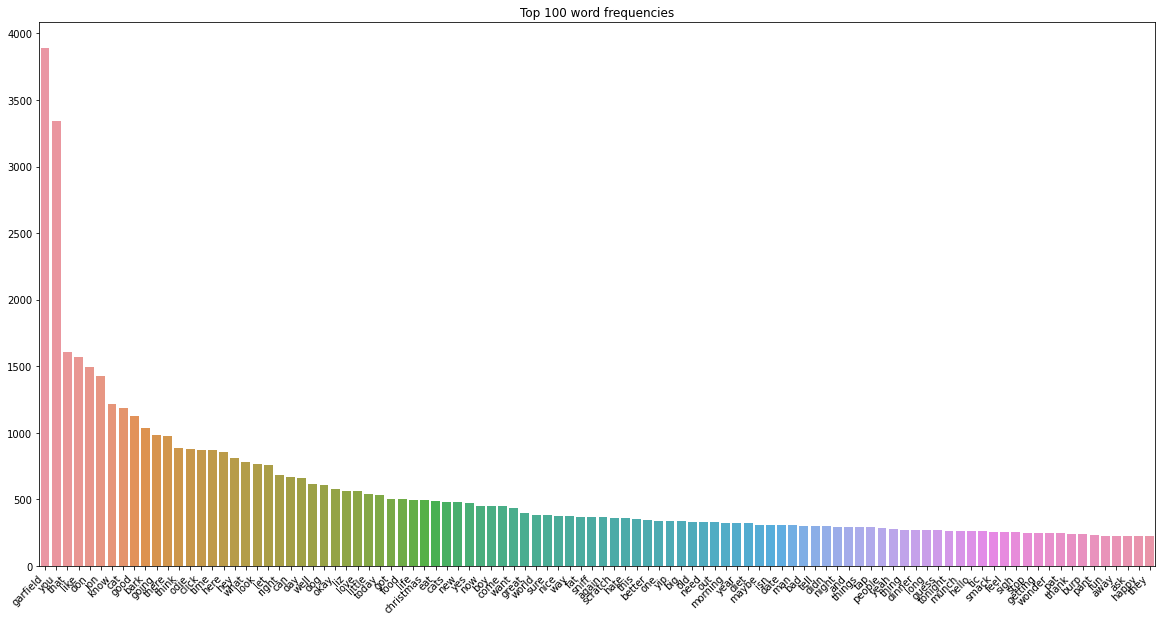

In [ ]:
top_100_words = words_sorted_by_frequency[0:100]
top_100_freqs = freqs[0:100]

plt.figure(figsize=(20,10))
plt.xticks(rotation = (45), fontsize = 10, va='top', ha='right')

sns.barplot(x=top_100_words, y=top_100_freqs).set(title='Top 100 word frequencies')
plt.show()

### Document length

In [ ]:
# map document -> token count
word_counts = corpus.apply(lambda doc: len(doc))
word_counts_stats = word_counts.describe()
print(word_counts_stats)
# mark shorter documents apart from the rest
word_colors = word_counts.apply(lambda c: '#tokens $\\leq 2$' if c <= 2 else '#tokens $\\geq 2$')

count    16262.000000
mean        10.999693
std          7.118157
min          0.000000
25%          7.000000
50%         10.000000
75%         14.000000
max        157.000000
Name: tokens, dtype: float64


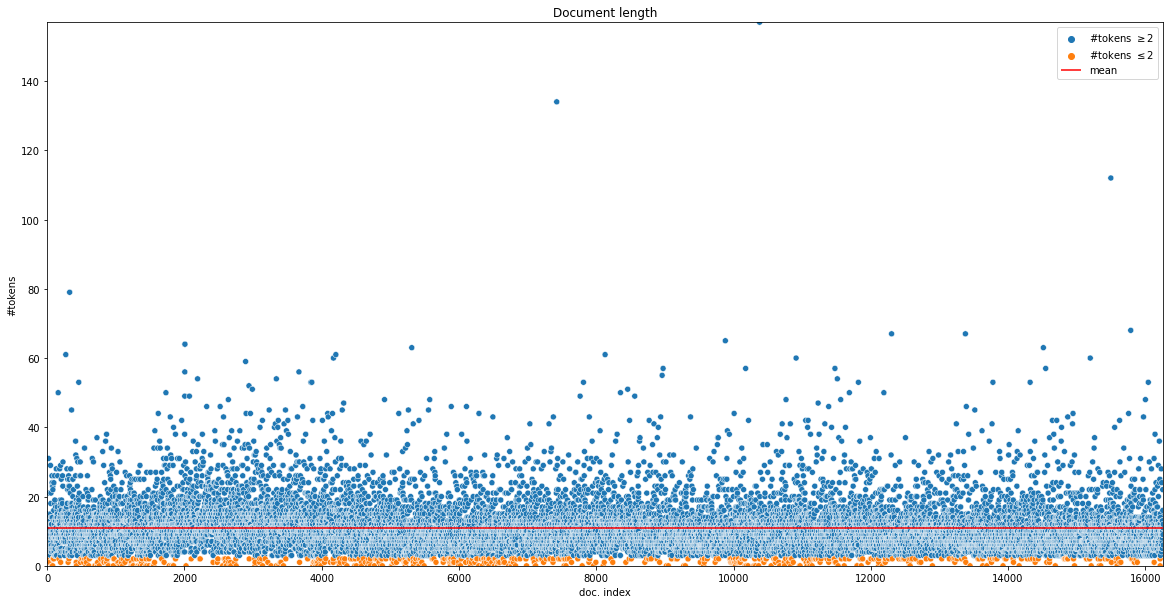

In [ ]:
plt.figure(figsize=(20,10))
# plot colored word counts as scatter points
ax = sns.scatterplot(x=df_sorted.index.array, y=word_counts, hue=word_colors).set(title='Document length')
# plot mean
plt.hlines(xmin=0, xmax=np.max(df_sorted.index.array), y=word_counts_stats['mean'], color='red', label='mean')
plt.xlabel('doc. index')
plt.ylabel('#tokens')
plt.margins(x=0, y=0)
plt.legend()
plt.show()
del ax, word_colors

In [ ]:
pd.set_option('display.max_colwidth', None)
longest_strip_idx = np.argmax(word_counts)
print(df_sorted.loc[longest_strip_idx, 'text'])

beep beep bip bip beep boop beep - boop bip beep boop beep boop boop bip beep bip beep bip boop bip beep - boop bip bip bip boop beep beepbip beep bip boop beep boop bip beep bip bip boop beep beep bip boop beep bip beep bip bip boop beep bipbeep - beep beep boop bip boop bip bip bip beep bip boop boop boop beep boop bip bip beep beep bip boop beep beep bip boop boop beep boop bip boop bip bip boop boop beep boop bip bip boop beep beepbip beep bip bip - beep beep bip boop boopbip beep boop bip bip boop boop beep bip bip beep bip boop boop beep beep boop bip bip beep boop boop bip beep boop beep bip bip bip boop bip beep beep beep bip boop bip bip boop beep bip beep bip boop bip boop bip beep bip beep - What areyou doing? Text messaging my Christmas list. bip send -


## Latent Semantic Analysis

### LSA space creation using truncated SVD

In [ ]:
from gensim.models import LsiModel
# create the lsi model/matrix factorization using the default #dimensions from gensim (k=200)
lsi = LsiModel(bow, num_topics=200, id2word=dictionary)

In [ ]:
# show U S V from the 200-rank approximation

# left singular vectors - terms
U = lsi.projection.u 

# eigenvalues from S
S = lsi.projection.s

# right singular vectors - docs
V = gensim.matutils.corpus2dense(lsi[bow], len(lsi.projection.s)).T / lsi.projection.s
Vt = np.transpose(V)

In [ ]:
print(f'Decomposition shapes:\nU={U.shape}, S={S.shape}, Vt={Vt.shape}')

Decomposition shapes:
U=(17190, 200), S=(200,), Vt=(200, 16262)


In [ ]:
# show some topics
lsi.show_topics()[0:10]

[(0,
  '1.000*"hic" + 0.015*"hichic" + 0.008*"sure" + 0.008*"whew" + 0.003*"huc" + 0.001*"sick" + 0.001*"hiccups" + 0.001*"iccitty" + 0.001*"hiccitty" + 0.001*"dog"'),
 (1,
  '0.960*"tic" + 0.275*"click" + 0.019*"you" + 0.019*"garfield" + 0.016*"that" + 0.012*"bark" + 0.011*"now" + 0.011*"food" + 0.010*"morning" + 0.009*"diary"'),
 (2,
  '0.958*"click" + -0.278*"tic" + 0.033*"garfield" + 0.026*"you" + 0.014*"there" + 0.013*"jon" + 0.012*"like" + 0.010*"one" + 0.010*"good" + 0.009*"clickclick"'),
 (3,
  '-0.989*"bark" + -0.069*"you" + -0.059*"dog" + -0.050*"garfield" + -0.025*"ask" + -0.024*"dear" + -0.023*"what" + -0.022*"like" + -0.022*"don" + -0.022*"that"'),
 (4,
  '0.477*"bip" + 0.415*"beep" + 0.391*"you" + 0.388*"boop" + 0.370*"garfield" + 0.115*"like" + 0.112*"don" + 0.103*"jon" + 0.102*"that" + 0.094*"know"'),
 (5,
  '-0.439*"you" + 0.434*"bip" + -0.420*"garfield" + 0.372*"beep" + 0.347*"boop" + -0.124*"like" + -0.122*"don" + -0.110*"that" + -0.105*"jon" + -0.101*"know"'),
 (6,


### Queries on the LSI/LSA space

Queries are a semantic extension over the boolean keyword match. The gold standard for this type of task is around 200-500 LSA dimensions (k in the low-rank approximation), so they will be performed on the 200-dim LSA space.

The dataset is not annotated with relevancy measures for certain documents.

For example, some manual queries:
- 'sleep' semantically finds some comics in which usually Garfield sleeps (as indicated by the 'Z' onomatopoeia).
- 'christmas' finds comics related to the holiday.
> Garfield is an international character. Therefore, I don't even use seasons. The only holiday I recognize is Christmas. I don't use rhyming gags, plays on words, colloquialisms, in an effort to make Garfield apply to virtually any society where he may appear. In an effort to keep the gags broad, the humor general and applicable to everyone, I deal mainly with eating and sleeping. That applies to everyone, anywhere.

   <cite>Jim Davis in an interview in Shapiro, W. (1982, December 12). LIVES: “The Cat That Rots the Intellect”. The Washington Post.</cite>

For more about Garfield, please read <cite>Engel, Iris B., "It’s Garfield’s World, We Just Live in It: An Exploration of Garfield the Cat as Icon, Money
Maker, and Beast" (2019).
Senior Projects Fall 2019. 3. https://digitalcommons.bard.edu/senproj_f2019/3 </cite>

In [ ]:
# transform a doc query into the lsa space
doc = "christmas"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]  # convert the query to LSI space
#print(vec_lsi)

In [ ]:
from gensim import similarities
index_lsi = similarities.MatrixSimilarity(lsi[bow])  # transform corpus (bow representation) to LSI space and index it

In [ ]:
sims = index_lsi[vec_lsi]  # perform a similarity query against the corpus
#print(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

In [ ]:
sims_sorted = sorted(enumerate(sims), key=lambda item: -item[1])
most_relevant_docs, most_relevant_scores = list(zip(*sims_sorted))
most_relevant_docs = list(most_relevant_docs)
df_sorted.iloc[most_relevant_docs[0:5]].style

,stripID,Date,text,url,tokens
1282,ga811225,1981-12-25 00:00:00,Christmas spirit... - It's not the giving. It's not the receiving. - It's the loving. Merry Christmas.,Comic,"['christmas', 'spirit', 'giving', 'receiving', 'loving', 'merry', 'christmas']"
7477,ga981225,1998-12-25 00:00:00,- - Merry Christmas!,Comic,"['merry', 'christmas']"
11126,ga081225,2008-12-25 00:00:00,- - Merry Christmas!,Comic,"['merry', 'christmas']"
12571,ga121211,2012-12-11 00:00:00,- - Christmas bone catalog.,Comic,"['christmas', 'bone', 'catalog']"
4194,ga891219,1989-12-19 00:00:00,- - He'll never find where I hid his Christmas present.,Comic,"['hid', 'christmas', 'present']"


In [ ]:
# convenient function to make a query and get the most relevant k comic strips
def get_top_k_relevant_docs(query: str, k: int, index: gensim.similarities.MatrixSimilarity):
  """Maps the query into the latent space and computes similarity wrt each of the documents in the corpus. 
  Returns the top k documents with the highest similarity to the query."""
  doc = query
  vec_bow = dictionary.doc2bow(doc.lower().split())
  vec_lsi = lsi[vec_bow]  # convert the query to LSI space
  sims = index[vec_lsi]  # perform a similarity query against the corpus
  sims_sorted = sorted(enumerate(sims), key=lambda item: -item[1])
  ranked_docs, ranked_scores = list(zip(*sims_sorted))
  return list(ranked_docs[:k]), list(ranked_scores[:k])

In [ ]:
top_docs, top_scores = get_top_k_relevant_docs(query='Actually, seeing the vet is not so bad', k=10, index=index_lsi)
df_sorted.iloc[top_docs].style

,stripID,Date,text,url,tokens
3182,ga870312,1987-03-12 00:00:00,Spinach. - It tastes bad. It looks bad. - SPLUT! It even sounds bad.,Comic,"['spinach', 'tastes', 'bad', 'looks', 'bad', 'splut', 'sounds', 'bad']"
14260,ga170806,2017-08-06 00:00:00,- - - - - * - YOU JUST RUINED a PERFECTLY BAD MOOD!,Comic,"['ruined', 'perfectly', 'bad', 'mood']"
11139,ga090108,2009-01-08 00:00:00,I'm elected to the bad habits hall of fame! - CRUMPLE CRUMPLE -,Comic,"['elected', 'bad', 'habits', 'hall', 'fame', 'crumple', 'crumple']"
11394,ga090920,2009-09-20 00:00:00,- - - - SPLOT - My bad.,Comic,"['splot', 'bad']"
15898,ga220207,2022-02-07 00:00:00,- I'm in a bad mood. - And its nam eis February.,Comic,"['bad', 'mood', 'nam', 'eis', 'february']"
6960,ga970724,1997-07-24 00:00:00,I'm in a bad mood. - - Relatively speaking.,Comic,"['bad', 'mood', 'relatively', 'speaking']"
2638,ga850914,1985-09-14 00:00:00,Why did we waste our evening at that movie? - And why was the photography so bad? - And why did they hand me three pairs of 3-D glasses?,Comic,"['waste', 'evening', 'movie', 'photography', 'bad', 'hand', 'pairs', 'glasses']"
13746,ga160305,2016-03-05 00:00:00,"My aunt Edna has a bad habit. - She was a finger licker. - But not her own. A lonely, lonely woman.",Comic,"['aunt', 'edna', 'bad', 'habit', 'finger', 'licker', 'own', 'lonely', 'lonely', 'woman']"
2081,ga840306,1984-03-06 00:00:00,"YAWN - GASP! - Waking up to my own bad breath is bad enough, but someone else's is unbearable.",Comic,"['yawn', 'gasp', 'waking', 'bad', 'breath', 'bad', 'enough', 'else', 'unbearable']"
3019,ga860930,1986-09-30 00:00:00,I gotta find something for this bad breath. - Aha! - Your breath smells funny. Yours would too if you gargled with after-shave.,Comic,"['gotta', 'bad', 'breath', 'aha', 'breath', 'smells', 'funny', 'gargled', 'after', 'shave']"


### Unsupervised topic extraction in LSA space

First, we will determine using the knee-point method the #topics/#dimension for a new LSI space.

Then, we will analyze the found topics.

Plot of the eigenvalues. The higher an eigenvalue for a dimension is, the more information it carries. This is because SVD outputs the best low-rank approximation for the input matrix, in this case the term x document matrix.

`kneed` is a library for finding knee points.

In [ ]:
import kneed

In [ ]:
eigen_x = np.arange(start=0, stop=len(S))
eigen_norm = S / np.linalg.norm(S)

In [ ]:
kneedle = kneed.KneeLocator(x=eigen_x, y=eigen_norm, S=1.0, curve="concave", direction="decreasing", online=True)
print(kneedle.all_knees)
num_topics_kneed = kneedle.knee
print(f'Knee point analysis suggests using k={num_topics_kneed}')

{32, 199, 10, 22, 62, 24, 28, 30}
Knee point analysis suggests using k=10


A knee point as local min of the curvature radius $k$ of the
iperbole function interpolating the data. This will be $k = \frac{y''}{{(1+y'^2)}^\frac{3}{2}}$

In [ ]:
# function to approximate derivative of an array
def derivative(x_data, y_data):
    N = len(x_data)
    delta_x = [x_data[i+1] - x_data[i] for i in range(N - 1)]
    x_prim = [(x_data[i+1] + x_data[i]) / 2. for i in range(N - 1)]
    y_prim = [(y_data[i+1] - y_data[i]) / delta_x[i] for i in range(N - 1)]
    return x_prim, y_prim
# compute 2nd derivative by calling it two times
x_prime, y_prime = derivative(eigen_x, eigen_norm)
x_bis, y_bis = derivative(x_prime, y_prime)
y_prime = y_prime[:-1]
# compute curvature according to formula
k = np.divide(y_bis, np.power(1 + np.square(y_prime), 1.5))

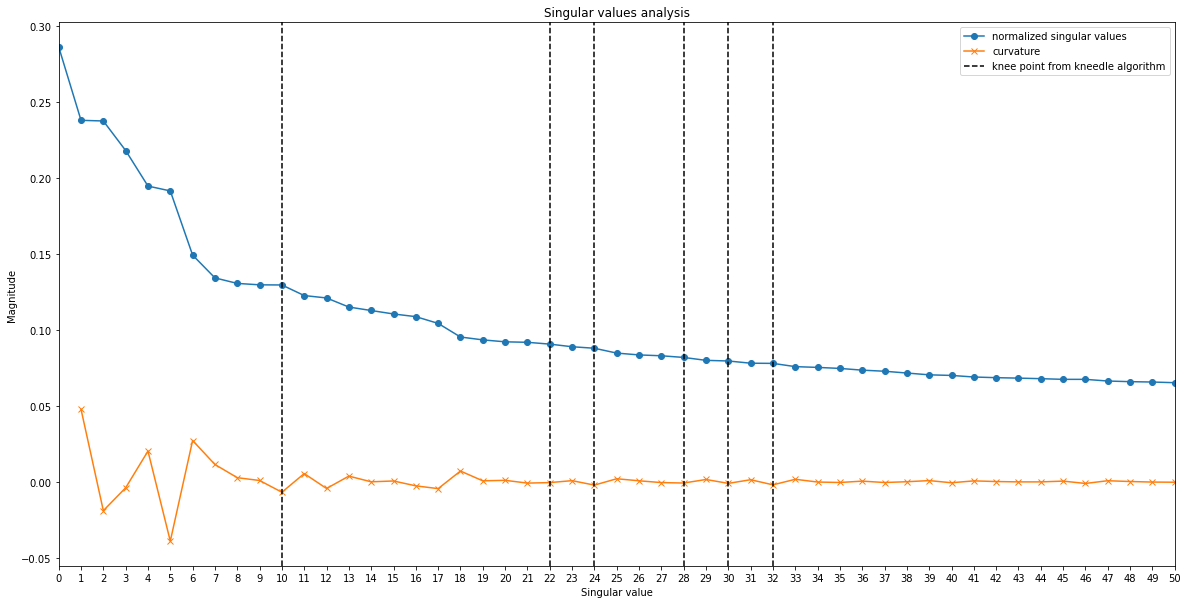

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Singular values analysis')
plt.plot(eigen_x, eigen_norm, '-o', label='normalized singular values')
plt.plot(x_bis, k, '-x', label='curvature')
#plt.vlines(x=list(kneedle.all_knees), ymin=ykneemin, ymax=ykneemax, linestyle='--', label='knee point from kneedle algorithm')
vlines = [plt.axvline(x = knee, color = 'black', linestyle='--') for knee in kneedle.all_knees]
vlines[0].set_label('knee point from kneedle algorithm')
plt.ylabel('Magnitude')
plt.xlabel('Singular value')
plt.xticks(eigen_x)
plt.xlim(0,50)
plt.legend()
plt.show()

Or we could compute a coherence measure according to a certain number of topics.
`CoherenceModel` does not provide stable results, though.

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
coherence_scores = []
# find the coherence score with a different number of topics
for i in range(1, num_topics_kneed+1):
    lsi_topics = LsiModel(bow, num_topics=i, id2word=dictionary)
    coherence_model = CoherenceModel(model=lsi_topics, texts=df_sorted['tokens'], dictionary=dictionary, coherence='c_v', topn=10)
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f'Coherence score with {i} topics: {coherence_score}')

Coherence score with 1 topics: 0.3657328176066942
Coherence score with 2 topics: 0.35919135102487215
Coherence score with 3 topics: 0.551908029823138
Coherence score with 4 topics: 0.40321734306230717
Coherence score with 5 topics: 0.3332048924342143
Coherence score with 6 topics: 0.35809251690606864
Coherence score with 7 topics: 0.32568592021423054
Coherence score with 8 topics: 0.42228119838063566
Coherence score with 9 topics: 0.3431670024260925
Coherence score with 10 topics: 0.3382050362241908


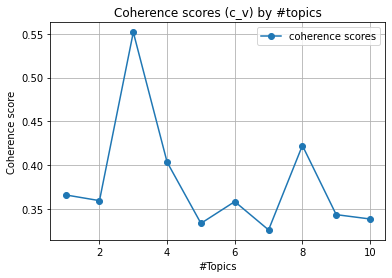

In [ ]:
topics_range = np.arange(1, num_topics_kneed+1)
plt.title('Coherence scores (c_v) by #topics')
plt.plot(topics_range, coherence_scores, '-o', label='coherence scores')
plt.ylabel('Coherence score')
plt.xlabel('#Topics')
plt.legend()
plt.grid()
plt.show()

## Testing with LDA (latent dirichelet allocation)

In [ ]:
#!pip install pyLDAvis

In [ ]:
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim_models
#from gensim.models import LdaModel
#lda = LdaModel(bow, num_topics=2, iterations=50, passes=5)
#pyLDAvis.enable_notebook()
#vis = gensimvis.prepare(lda, bow, dictionary=dictionary)
#vis

## Comic strip retrieval with Deep metric learning

We will compare the previous basic LSI model with two sentence transformers.
One will be a pretrained one from a very large corpora of multiple text sources, the other will be a finetuned version of the pretrained one.

The finetuning will be done on 80% of the Garfield sentences, and the evaluation for all models (LSI, pretrained, finetuned) will be done on a held-out set of 20% of the sentences, and on the full dataset maybe (since this will be a common use-case).

## Dataframe setup for deep metric learning



In [ ]:
import torch
from torch import topk
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

### 1. Divide each strip into sentences

In [ ]:
def metric_learning_setup_text(text):
  # split around the panel
  out = text.split('-')
  # remove spaces
  out = [sentence.strip(' ') for sentence in out]
  # do not return empty strings
  out = [sentence for sentence in out if len(sentence) >= 1]
  return out

In [ ]:
# explode turns column with list in multiple rows with one element in each column
sentences = df_sorted['text'].apply(metric_learning_setup_text).explode().rename("sentence")
sentences

0        Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield.
0                  Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon.
0                                       Our only thought is to entertain you. Feed me.
1                                 Happy birthday, Garfield. I have a surprise for you.
1                                                                     A rubber mousey!
                                             ...                                      
16260                                     Look! Irma's Diner just expanded their menu.
16260                                      They added three kinds of meatloaf... Cool.
16260                                                  Ooooh... And 23 kinds of bacon!
16261                                                           WAIT HERE FOR SURPRISE
16261                                     It's sure quiet around here today. Surprise!
Name: sentence, Length: 52119, dtype: objec

In [ ]:
df_sentences = df_sorted.join(sentences)
#df_sentences.drop(columns='tokens', inplace=True)

df_sentences.index.name = 'old index'
df_sentences = df_sentences.reset_index(drop=False)
df_sentences = df_sentences.dropna()
# apply function to all sentences (for lsi model)
df_sentences['tokens'] = df_sentences['sentence'].apply(lambda x: preprocess(x))
df_sentences

,old index,stripID,Date,text,url,tokens,sentence
0,0,ga780619,1978-06-19,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield. - Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon. - Our only thought is to entertain you. Feed me.","<a href=""https://www.gocomics.com/garfield/1978/06/19"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[there, jon, arbuckle, cartoonist, cat, garfield]","Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield."
1,0,ga780619,1978-06-19,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield. - Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon. - Our only thought is to entertain you. Feed me.","<a href=""https://www.gocomics.com/garfield/1978/06/19"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[there, garfield, cat, cartoonist, jon]","Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon."
2,0,ga780619,1978-06-19,"Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield. - Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon. - Our only thought is to entertain you. Feed me.","<a href=""https://www.gocomics.com/garfield/1978/06/19"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[thought, entertain, you, feed]",Our only thought is to entertain you. Feed me.
3,1,ga780620,1978-06-20,"Happy birthday, Garfield. I have a surprise for you. - A rubber mousey! - Could've used a little salt...","<a href=""https://www.gocomics.com/garfield/1978/06/20"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[happy, birthday, garfield, surprise, you]","Happy birthday, Garfield. I have a surprise for you."
4,1,ga780620,1978-06-20,"Happy birthday, Garfield. I have a surprise for you. - A rubber mousey! - Could've used a little salt...","<a href=""https://www.gocomics.com/garfield/1978/06/20"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[rubber, mousey]",A rubber mousey!
...,...,...,...,...,...,...,...
52114,16260,ga230204,2023-02-04,Look! Irma's Diner just expanded their menu. - They added three kinds of meatloaf... Cool. - Ooooh... And 23 kinds of bacon!,"<a href=""https://www.gocomics.com/garfield/2023/02/04"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[look, irma, diner, expanded, menu]",Look! Irma's Diner just expanded their menu.
52115,16260,ga230204,2023-02-04,Look! Irma's Diner just expanded their menu. - They added three kinds of meatloaf... Cool. - Ooooh... And 23 kinds of bacon!,"<a href=""https://www.gocomics.com/garfield/2023/02/04"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[added, kinds, meatloaf, cool]",They added three kinds of meatloaf... Cool.
52116,16260,ga230204,2023-02-04,Look! Irma's Diner just expanded their menu. - They added three kinds of meatloaf... Cool. - Ooooh... And 23 kinds of bacon!,"<a href=""https://www.gocomics.com/garfield/2023/02/04"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[ooooh, kinds, bacon]",Ooooh... And 23 kinds of bacon!
52117,16261,ga230205,2023-02-05,- - WAIT HERE FOR SURPRISE - - - - It's sure quiet around here today. Surprise!,"<a href=""https://www.gocomics.com/garfield/2023/02/05"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[wait, surprise]",WAIT HERE FOR SURPRISE


In [ ]:
# verify that indexes still have the correct form
#for i in range(len(df_sentences_train)):
#    old_index = df_sentences_train.loc[i, 'old index']
#    strip_eval = df_sentences_train.loc[i, 'stripID']
#    strip_sorted = df_sorted.iloc[old_index]['stripID']
#    #print(strip, samestrip)
#    assert(strip_eval=='strip_sorted')

 ### 2. Train - test split
 - Take out 500 strips for testing purposes, so that their sentences will not be trained on
 - Use remaining strips for training the `SentenceTransformer`

In [ ]:
# ON KAGGLE IT DOES NOT WORK
#train_stripIDs, val_stripIDs, test_stripIDs = random_split(df_sorted['stripID'], [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))
#train_stripIDs = train_stripIDs.dataset[train_stripIDs.indices].values
#val_stripIDs = val_stripIDs.dataset[val_stripIDs.indices].values
#test_stripIDs = test_stripIDs.dataset[test_stripIDs.indices].values

In [ ]:
#train_stripIDs, val_stripIDs, test_stripIDs = np.split(df_sorted['stripID'].sample(frac=1, random_state=42),
#                                [int(.8*len(df_sorted)), int(.9*len(df_sorted))])
test_stripIDs = df_sorted['stripID'].sample(n=500, random_state=42)
len(test_stripIDs.unique())

500

In [ ]:
#print(len(train_stripIDs), len(val_stripIDs), len(test_stripIDs))
#print(len(train_stripIDs), len(test_stripIDs))
is_test = df_sentences['stripID'].isin(test_stripIDs)
df_sentences_test = df_sentences[is_test].reset_index(drop=True)

df_sentences_train = df_sentences[~is_test].reset_index(drop=True)

#is_val = df_sentences['stripID'].isin(val_stripIDs)
#df_sentences_val = df_sentences[is_val].reset_index(drop=True)

#print(df_sentences_train.shape, df_sentences_val.shape, df_sentences_test.shape)
print(df_sentences_train.shape, df_sentences_test.shape)

df_sentences_train.loc[40:50]

(50464, 7) (1546, 7)


,old index,stripID,Date,text,url,tokens,sentence
40,15,ga780704,1978-07-04,I really shouldn't eat that fish... - - Call it an ethnic weakness.,"<a href=""https://www.gocomics.com/garfield/1978/07/04"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[shouldn, eat, fish]",I really shouldn't eat that fish...
41,15,ga780704,1978-07-04,I really shouldn't eat that fish... - - Call it an ethnic weakness.,"<a href=""https://www.gocomics.com/garfield/1978/07/04"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[ethnic, weakness]",Call it an ethnic weakness.
42,16,ga780705,1978-07-05,itch scratch scratch - scratch! scratch! scratch! scratch! itch scratch! scratch! scratch! scratch! - AARRRGH!,"<a href=""https://www.gocomics.com/garfield/1978/07/05"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[itch, scratch, scratch]",itch scratch scratch
43,16,ga780705,1978-07-05,itch scratch scratch - scratch! scratch! scratch! scratch! itch scratch! scratch! scratch! scratch! - AARRRGH!,"<a href=""https://www.gocomics.com/garfield/1978/07/05"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[scratch, scratch, scratch, scratch, itch, scratch, scratch, scratch, scratch]",scratch! scratch! scratch! scratch! itch scratch! scratch! scratch! scratch!
44,16,ga780705,1978-07-05,itch scratch scratch - scratch! scratch! scratch! scratch! itch scratch! scratch! scratch! scratch! - AARRRGH!,"<a href=""https://www.gocomics.com/garfield/1978/07/05"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>",[aarrrgh],AARRRGH!
45,17,ga780706,1978-07-06,SNIFF! - Cat food... - The bouquet leaves something to be desired.,"<a href=""https://www.gocomics.com/garfield/1978/07/06"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>",[sniff],SNIFF!
46,17,ga780706,1978-07-06,SNIFF! - Cat food... - The bouquet leaves something to be desired.,"<a href=""https://www.gocomics.com/garfield/1978/07/06"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[cat, food]",Cat food...
47,17,ga780706,1978-07-06,SNIFF! - Cat food... - The bouquet leaves something to be desired.,"<a href=""https://www.gocomics.com/garfield/1978/07/06"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[bouquet, leaves, desired]",The bouquet leaves something to be desired.
48,18,ga780707,1978-07-07,"Ah, a curtain upon which to sharpen my claws. - - I hate double-knit.","<a href=""https://www.gocomics.com/garfield/1978/07/07"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[curtain, sharpen, claws]","Ah, a curtain upon which to sharpen my claws."
49,18,ga780707,1978-07-07,"Ah, a curtain upon which to sharpen my claws. - - I hate double-knit.","<a href=""https://www.gocomics.com/garfield/1978/07/07"" rel=""noopener noreferrer"" target=""_blank"">Comic</a>","[hate, double]",I hate double


### 3. Make a dataset with previous that outputs tuples of (query, positive, negative, stripID)

In [ ]:
from sentence_transformers import InputExample

In [ ]:
class GarfieldDataset(Dataset):
  def __init__(self, dataset, mode='triplet'):
    self.dataset = dataset
    self.strip_number = dataset['old index'].values
    self.sentences = dataset['sentence'].values
    self.mode = mode
    
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # return query, positive, negative and stripID for query index if mode is for triplet loss, otherwise 
    # only query and positive (assumed for multiplenegativeloss)
    query = self.dataset.loc[idx, 'sentence']

    # pos = another sentence in the same strip
    positives_list = self.sentences[(self.strip_number == self.dataset.loc[idx, 'old index'])]
    positives_list = positives_list[positives_list != query]
    try:
        positive = random.choice(positives_list)
    except: positive = ''

    #stripID = self.dataset.loc[idx, 'stripID']
    example = None
    if self.mode == 'triplet':
        negatives_list = self.sentences[(self.strip_number != self.dataset.loc[idx, 'old index'])]
        negatives_list = negatives_list[negatives_list != query]

        negative = random.choice(negatives_list)
        example = InputExample(texts = [query, positive, negative])
    elif self.mode=='mn': 
        example = InputExample(texts = [query, positive])
    #return query, positive, negative, stripID
    return example

Split the data in train, test

In [ ]:
train_triplet = GarfieldDataset(df_sentences_train, mode='triplet')
train_mn = GarfieldDataset(df_sentences_train, mode='mn')

In [ ]:
print('Triplet example:', train_triplet.__getitem__(0).texts)
print('MN example:', train_mn.__getitem__(0).texts)

Triplet example: ["Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield.", "Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon.", "I'll feed you in a minute, Garfield."]
MN example: ["Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield.", 'Our only thought is to entertain you. Feed me.']


## Sentence Transformer model setup and training

In [ ]:
# https://huggingface.co/blog/how-to-train-sentence-transformers
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from sentence_transformers import losses
#https://www.sbert.net/docs/package_reference/evaluation.html

In [ ]:
import shutil
import os
import gc

Consider having the .zip files in the local directory

In [ ]:
!git clone https://github.com/EnricoBenedetti/GarfieldRetrieve

Cloning into 'GarfieldRetrieve'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 17 (delta 0), reused 2 (delta 0), pack-reused 14
Unpacking objects: 100% (17/17), 214.52 MiB | 10.10 MiB/s, done.


In [ ]:
load_finetuned_from_local = True

model_id = "sentence-transformers/all-MiniLM-L6-v2"
# load base pretrained
model_base = SentenceTransformer(model_id)
model_finetuned_triplet = SentenceTransformer(model_id)
model_finetuned_mn = SentenceTransformer(model_id)

# load finetuned state_dict from my repository
if load_finetuned_from_local:
    os.chdir("/content/GarfieldRetrieve")
    #shutil.unpack_archive('finetuned_garfield_triplet.zip', 'finetuned_garfield_triplet')
    #os.chdir("finetuned_garfield_triplet/")
    #model_finetuned_triplet = SentenceTransformer('finetuned_garfield_triplet')
    
    model_finetuned_triplet.load_state_dict(torch.load('garfield_finetuned_triplet_state'))
    model_finetuned_mn.load_state_dict(torch.load('garfield_finetuned_mn_state', weights_only=True))
    #os.chdir("/content/GarfieldRetrieve")
    #shutil.unpack_archive('finetuned_garfield_mn.zip', 'finetuned_garfield_mn')
    #os.chdir("finetuned_garfield_mn/")
    #model_finetuned_mn = SentenceTransformer('finetuned_garfield_mn')
    os.chdir("/content")
    print('Loaded finetuned models from folder.')

Loaded from folder.


Losses

`MultipleNegativesRankingLoss`: The examples are a pair of positive sentences without a label. In this case, the positive for a sentence is another sentence from the same strip. Since the majority of all the sentences in the dataset are then negative for a query (because they come from different strips), this loss should be okay to embed closer together sentences from the same strip.

`TripletLoss`: The example is a triplet (anchor, positive, negative) without classes or labels for the sentences. In this case the anchor is a sentence from strip X, positive is another sentence in strip X, and negative is a sentence from a different strip. With this loss sometimes the example are already too easy (distance anchor-positive is already smaller than the distance anchor-negative), so hard and semi-hard negative mining could be adopted to improve training.

In [ ]:
train_loss_triplet = losses.TripletLoss(model=model_finetuned_triplet)
train_loss_mn = losses.MultipleNegativesRankingLoss(model=model_finetuned_mn)

train_dataloader_triplet = DataLoader(train_triplet, shuffle=True, batch_size=32)
train_dataloader_mn = DataLoader(train_mn, shuffle=True, batch_size=32)

Finetune with Triplet Loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_finetuned_triplet.fit(train_objectives=[(train_dataloader_triplet, train_loss_triplet)], epochs=10) 

#model_finetuned_triplet.save('finetuned_garfield_triplet')
#shutil.make_archive('finetuned_garfield_triplet', 'zip', base_dir='finetuned_garfield_triplet')

torch.save(model_finetuned_triplet.state_dict(),'garfield_finetuned_triplet_state')

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1577 [00:00<?, ?it/s]

Finetune with Multiple Negatives Loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()

model_finetuned_mn.fit(train_objectives=[(train_dataloader_mn, train_loss_mn)], epochs=10) 

#model_finetuned_mn.save('finetuned_garfield_mn')
#shutil.make_archive('finetuned_garfield_mn', 'zip', base_dir='finetuned_garfield_mn')
torch.save(model_finetuned_mn.state_dict(),'garfield_finetuned_mn_state')

## Computing Embeddings

In this section all strips in the corpus are encoded passing through the models. (GPU is needed to avoid using up a lot of time)

In [ ]:
embeddings_base = model_base.encode(df_sorted['text'], convert_to_tensor=True)
embeddings_finetuned_triplet = model_finetuned_triplet.encode(df_sorted['text'], convert_to_tensor=True)
embeddings_finetuned_mn = model_finetuned_mn.encode(df_sorted['text'], convert_to_tensor=True)

In [ ]:
# Find the closest k documents of the corpus for each query sentence based on cosine similarity on a certain model
def top_k_retrieval(query, df, corpus_embeddings, model, k=5, verbose=False):
    k = min(k, len(corpus_embeddings))
    query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)

    # We use cosine-similarity and torch.topk to find the highest scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=k)
    if verbose:
        print(top_results)
        print("\n\n======================\n\n")
        print("Query:", query)
        print(f"\nTop {k} most similar sentences in corpus:")

        for score, idx in zip(top_results[0], top_results[1]):
          print(df.iloc[int(idx)]['text'], "(Score: {:.4f})".format(score))
    return top_results[0].cpu().numpy(), top_results[1].cpu().numpy().astype('int')

In [ ]:
# Query sentences:
query = "Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield."
top_k_retrieval(query, df_sorted, embeddings_base, model_base, k=10, verbose=True)

torch.return_types.topk(
values=tensor([0.9028, 0.7011, 0.6851, 0.6671, 0.6616, 0.6605, 0.6595, 0.6543, 0.6498,
        0.6491], device='cuda:0'),
indices=tensor([    0,   587,  2353, 13412,  8007,  1198, 12617,  5365, 11603,   643],
       device='cuda:0'))




Query: Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield.

Top 10 most similar sentences in corpus:
Hi, there...I'm Jon Arbuckle. I'm a cartoonist, and this is my cat, Garfield. - Hi, there. I'm Garfield. I'm a cat, and this is my cartoonist, Jon. - Our only thought is to entertain you. Feed me. (Score: 0.9028)
Morning, Liz. Jon here. I'm bringing Garfield in for a checkup today. - I know you've been wanting to get to know me better, so why don't you make it a late appointment and we'll go to dinner afterward. - Jon...Jon Arbuckle. (Score: 0.7011)
Garfield, I'm going to a cartoonists' convention, and the motel where I'm staying won't accept pets. - Sorry, Odie. You can't go. - Garfield, YOU are a pet.

(array([0.9027651 , 0.7010516 , 0.6850813 , 0.6671114 , 0.6615506 ,
        0.66048455, 0.6595343 , 0.65434575, 0.64977705, 0.6491077 ],
       dtype=float32),
 array([    0,   587,  2353, 13412,  8007,  1198, 12617,  5365, 11603,
          643]))

## Retrieval System evaluation

The performance of `SentenceTransformer`-based retrieval is compared across different training conditions (no finetuning, finetuning with triplet loss, finetuning with multiple negatives loss) and against the `LSI` model.

Measures: Precision, Recall, F-measure up to $k$ strips retrieved, ordered by similarity wrt the query.

The test queries are the sentences from the held-out set. The `SentenceTransformers` that have trained have not seen these strips, while the `LSI` model has been created using all comics.

In [ ]:
df_evaluation = df_sentences_test

### Functions for query analysis

In [ ]:
# adapted from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C7/C7S3_Evaluation.html
def plot_PR_curve(P_Q, R_Q, figsize=(3, 3)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    plt.plot(R_Q, P_Q, linestyle='--', marker='o', color='k', mfc='r')
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    ax.set_aspect('equal', 'box')
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.tight_layout()
    return fig, ax

def compute_prf_metrics(I, score, I_Q):
    """Compute precision, recall, F-measures and other
    evaluation metrics for document-level retrieval

    Notebook: C7/C7S3_Evaluation.ipynb

    Args:
        I (np.ndarray): Array of items
        score (np.ndarray): Array containing the score values of the times
        I_Q (np.ndarray): Array of relevant (positive) items

    Returns:
        P_Q (float): Precision
        R_Q (float): Recall
        F_Q (float): F-measures sorted by rank
        BEP (float): Break-even point
        F_max (float): Maximal F-measure
        P_average (float): Mean average
        X_Q (np.ndarray): Relevance function
        rank (np.ndarray): Array of rank values
        I_sorted (np.ndarray): Array of items sorted by rank
        rank_sorted (np.ndarray): Array of rank values sorted by rank
    """
    # Compute rank and sort documents according to rank
    K = len(I)
    index_sorted = np.flip(np.argsort(score))
    I_sorted = I[index_sorted]
    rank = np.argsort(index_sorted) + 1
    rank_sorted = np.arange(1, K+1)

    # Compute relevance function X_Q (indexing starts with zero)
    X_Q = np.isin(I_sorted, I_Q)

    # Compute precision and recall values (indexing starts with zero)
    M = len(I_Q)
    P_Q = np.cumsum(X_Q) / np.arange(1, K+1)
    R_Q = np.cumsum(X_Q) / M

    # Break-even point
    BEP = P_Q[M-1]
    # Maximal F-measure
    sum_PR = P_Q + R_Q
    sum_PR[sum_PR == 0] = 1  # Avoid division by zero
    F_Q = 2 * (P_Q * R_Q) / sum_PR
    F_max = F_Q.max()
    # Average precision
    P_average = np.sum(P_Q * X_Q) / len(I_Q)

    return P_Q, R_Q, F_Q, BEP, F_max, P_average, X_Q, rank, I_sorted, rank_sorted

def full_query_analysis(I, score, I_Q):
    output = compute_prf_metrics(I, score, I_Q)
    P_Q, R_Q, F_Q, BEP, F_max, P_average, X_Q, rank, I_sorted, rank_sorted = output

    # Arrange output as tables
    score_sorted = np.flip(np.sort(score))
    df_query_metrics = pd.DataFrame({'Rank': rank_sorted, 'ID': I_sorted,
                   'Score': score_sorted,
                   'Is Relevant': X_Q, 
                   'Prec(r)': P_Q, 
                   'Rec(r)': R_Q,
                   'F-score(r)': F_Q})
    fig, ax = plot_PR_curve(P_Q, R_Q, figsize=(3,3))
    ax.plot(BEP, BEP, color='green', marker='o', fillstyle='none', markersize=15)
    ax.set_title('PR curve')

    plt.show()

    print('Break-even point = %.2f' % BEP)
    print('F_max = %.2f' % F_max)
    print('Average precision =', np.round(P_average, 5))
    print(df_query_metrics)

### Functions that compute (I, I_Q, score) for the different models

- I: the relevant documents retrieved;
- I_Q: the ground truth relevant document/strip,
- score: the similarity scores i.e. cosine similarity, of query wrt I

In [ ]:
def get_I_score_I_Q_for_sentence_embedder(query_idx, df, embeddings, model, k=10):
    query = df.loc[query_idx, 'sentence']
    I_Q = [df.loc[query_idx, 'old index']]
    score, I = top_k_retrieval(query, df, embeddings, model, k=k, verbose=False)
    return I, score, I_Q

Query sentence: What are those for? My snow fly..
Relevant strip: ([10418], 'ga070117')
Full text: Paddles and cookies? - What are those for? My snow fly. -


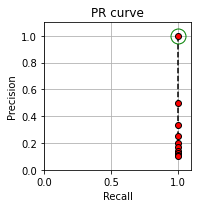

Break-even point = 1.00
F_max = 1.00
Average precision = 1.0
   Rank     ID     Score  Is Relevant   Prec(r)  Rec(r)  F-score(r)
0     1  10418  0.733150         True  1.000000     1.0    1.000000
1     2   1753  0.471770        False  0.500000     1.0    0.666667
2     3  12556  0.430098        False  0.333333     1.0    0.500000
3     4   9727  0.400390        False  0.250000     1.0    0.400000
4     5   7346  0.382432        False  0.200000     1.0    0.333333
5     6     88  0.376588        False  0.166667     1.0    0.285714
6     7  10823  0.373618        False  0.142857     1.0    0.250000
7     8   2963  0.372670        False  0.125000     1.0    0.222222
8     9   2323  0.364746        False  0.111111     1.0    0.200000
9    10  13009  0.364636        False  0.100000     1.0    0.181818


In [ ]:
query_idx = 1002
I, score, I_Q = get_I_score_I_Q_for_sentence_embedder(query_idx, df_evaluation, embeddings_base, model_base, k=10)
query = df_evaluation.loc[query_idx, 'sentence']
print(f"Query sentence: {query}.\nRelevant strip: {I_Q, df_evaluation.loc[query_idx, 'stripID']}")
print(f"Full text: {df_evaluation.loc[query_idx, 'text']}")
full_query_analysis(I, score, I_Q)

Query sentence: What are those for? My snow fly..
Relevant strip: ([10418], 'ga070117')
Full text: Paddles and cookies? - What are those for? My snow fly. -


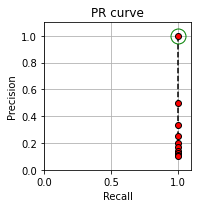

Break-even point = 1.00
F_max = 1.00
Average precision = 1.0
   Rank     ID     Score  Is Relevant   Prec(r)  Rec(r)  F-score(r)
0     1  10418  0.733150         True  1.000000     1.0    1.000000
1     2   1753  0.471770        False  0.500000     1.0    0.666667
2     3  12556  0.430098        False  0.333333     1.0    0.500000
3     4   9727  0.400390        False  0.250000     1.0    0.400000
4     5   7346  0.382432        False  0.200000     1.0    0.333333
5     6     88  0.376588        False  0.166667     1.0    0.285714
6     7  10823  0.373618        False  0.142857     1.0    0.250000
7     8   2963  0.372670        False  0.125000     1.0    0.222222
8     9   2323  0.364746        False  0.111111     1.0    0.200000
9    10  13009  0.364636        False  0.100000     1.0    0.181818


In [ ]:
query_idx = 1002
I, score, I_Q = get_I_score_I_Q_for_sentence_embedder(query_idx, df_evaluation, embeddings_finetuned_triplet, model_finetuned_triplet, k=10)
query = df_evaluation.loc[query_idx, 'sentence']
print(f"Query sentence: {query}.\nRelevant strip: {I_Q, df_evaluation.loc[query_idx, 'stripID']}")
print(f"Full text: {df_evaluation.loc[query_idx, 'text']}")
full_query_analysis(I, score, I_Q)

In [ ]:
def get_I_score_I_Q_for_LSI_model(query_idx, df, embeddings, model, k=10):
  """Maps the query into the latent space and computes similarity wrt each of the documents in the corpus. 
  Returns the top k documents with the highest similarity to the query."""
  doc = df.loc[query_idx,'tokens']
  vec_bow = dictionary.doc2bow(doc)
  vec_lsi = lsi[vec_bow]  # convert the query to LSI space
  sims = index_lsi[vec_lsi]  # perform a similarity query against the corpus
  sims_sorted = sorted(enumerate(sims), key=lambda item: -item[1])
  ranked_docs, ranked_scores = list(zip(*sims_sorted))
  I = np.array(ranked_docs[:k])
  score = np.array(ranked_scores[:k])
  I_Q = [df.loc[query_idx, 'old index']]
  return I, score, I_Q

Query: What are those for? My snow fly.
Retrieved:  10447                                                                                                                                                Snow! - It's a blizzard! - I'm flattered.
10418                                                                                                                                Paddles and cookies? - What are those for? My snow fly. -
8255                                                                                                             - I'm pretty much sick of winter. - ENOUGH WITH tHE SNOW ALREADY! - - - - zip
7241                                                                                                                                                             plip - bzzzzzzzz - Fly paper.
10610                                                                                                   - Uh-oh. - I've forgotten what I'm on hold for. We refer to this as a "senior mo

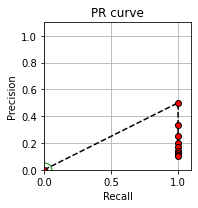

Break-even point = 0.00
F_max = 0.67
Average precision = 0.5
   Rank     ID     Score  Is Relevant   Prec(r)  Rec(r)  F-score(r)
0     1  10447  0.607052        False  0.000000     0.0    0.000000
1     2  10418  0.593204         True  0.500000     1.0    0.666667
2     3   8255  0.422151        False  0.333333     1.0    0.500000
3     4   7241  0.399640        False  0.250000     1.0    0.400000
4     5  10610  0.367159        False  0.200000     1.0    0.333333
5     6   5295  0.362901        False  0.166667     1.0    0.285714
6     7   6566  0.331235        False  0.142857     1.0    0.250000
7     8   5690  0.329758        False  0.125000     1.0    0.222222
8     9  14750  0.329264        False  0.111111     1.0    0.200000
9    10  12161  0.327909        False  0.100000     1.0    0.181818


In [ ]:
query_idx = 1002
print('Query:', df_evaluation.loc[query_idx,'sentence'])
I, score, I_Q = get_I_score_I_Q_for_LSI_model(query_idx, df_evaluation, index_lsi, lsi, k=10)
print('Retrieved: ', df_sorted.iloc[I]['text'])
full_query_analysis(I, score, I_Q)

### Comparison of results across the considered models

In [ ]:
def compute_performances_on_whole_dataset(k, df, retrieval_function, kwargs):
    """Compute precision, recall, F-measures and other
    evaluation metrics for document-level retrieval on all queries in dataframe for rank up to k.

    Args:
        df: Dataframe with columns "sentence", "old index".
        retrieval_function: function that retrieves I, score, I_Q.
        k: max number of documents retrieved.
        kwargs = Arguments for retrieval_function, such as the embeddings of the corpus documents, etc.

    Returns:
        Dataframe with MAP, Precision, Recall, Fscore@1,5,10 columms."""

    avg_precision = np.zeros(k)
    avg_recall = np.zeros(k)
    avg_fscore = np.zeros(k)
    avg_MAP = 0
    
    for query_idx in tqdm(range(len(df))):
        # compute metrics for each query, and accumulate them
        #score, I = top_k_retrieval(df['sentence'][query_idx], embeddings, model, k=k, verbose=False)
        #I_Q = [df.loc[query_idx, 'old index']]
        I, score, I_Q = retrieval_function(query_idx = query_idx, **kwargs)
        output = compute_prf_metrics(I, score, I_Q)
        P_Q, R_Q, F_Q, BEP, F_max, P_average, X_Q, rank, I_sorted, rank_sorted = output

        avg_precision += P_Q
        avg_recall += R_Q
        avg_fscore += F_Q
        avg_MAP += P_average
        
    # divide by n. of queries made
    avg_precision /= len(df)
    avg_recall /= len(df)
    avg_fscore /= len(df)
    avg_MAP /= len(df)
    
    results = pd.DataFrame({'MAP' : avg_MAP, 
                            'Precision@k' : [avg_precision],
                            'Recall@k' : [avg_recall],
                            'Fscore@k' : [avg_fscore]})
    #for ki in range(k):
    #    results[f'Precision@{ki+1}'] = avg_precision[ki] 
    #    results[f'Recall@{ki+1}'] = avg_recall[ki]
    #    results[f'Fscore@{ki+1}'] = avg_fscore[ki]
    #results.loc[0, f'Precision@k'] = avg_precision[0]
    #results.loc[0, f'Recall@k'] = avg_precision[0]
    #results.loc[0, f'Fscore@k'] = avg_precision[0]
    
    return results

In [ ]:
def create_results_df(df_evaluation):
    models = [model_base, model_finetuned_triplet, model_finetuned_mn, lsi]
    embeddings = [embeddings_base, embeddings_finetuned_triplet, embeddings_finetuned_mn, index_lsi]
    names = ['base', 'finetuned_triplet', 'finetuned_mn', 'lsi']
    partial_results = []
    # compute metrics for each model
    for model, embedding, name in zip(models, embeddings, names):
        print(f'Evaluating {name}')
        if not(name == "lsi"):
            partial_result = compute_performances_on_whole_dataset(k=10, 
                                                     df=df_evaluation,
                                                     retrieval_function=get_I_score_I_Q_for_sentence_embedder,
                                                     kwargs={'df':df_evaluation,
                                                           'embeddings': embedding,
                                                           'model': model})
        else:
            partial_result = compute_performances_on_whole_dataset(k=10, 
                                                     df=df_evaluation[:100],
                                                     retrieval_function=get_I_score_I_Q_for_LSI_model,
                                                     kwargs={'df':df_evaluation,
                                                           'embeddings': embedding,
                                                           'model': model})
        # name
        partial_result.rename(index={0: name}, inplace=True)
        # add
        partial_results.append(partial_result)
    results = pd.concat(partial_results)
    return results

Regarding the task of strip retrieval from a sentence, we compute the metrics wrt to multiple sets of queries.

- Sentences in the whole dataset. We will see that the finedtuned version using multiple negatives loss outperforms the base sentence encoder.
- Held-out sentences in the test dataset. We can observe that the general pretrained-version is still better at generalizing.

In [ ]:
results_general = create_results_df(df_evaluation = df_sentences_train) # this runs for a long time, we can take a subset of them as sample
results_test = create_results_df(df_evaluation = df_sentences_test)

Evaluating base


100%|██████████| 1546/1546 [00:12<00:00, 122.83it/s]


Evaluating finetuned_triplet


100%|██████████| 1546/1546 [00:13<00:00, 114.68it/s]


Evaluating finetuned_mn


100%|██████████| 1546/1546 [00:12<00:00, 123.49it/s]


Evaluating lsi


100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


In [ ]:
def plot_results(x, y, label, filled_marker_style):
  plt.plot(x, y, fillstyle = "none", label=label, **filled_marker_style)

def plot_metrics_multiple_models(dataframe, title, metric): #the metric you want to print: "f1-score", "precision", "recall"
  colors = ['blue', 'orange', 'green', 'red']
  filled_marker_style = dict(marker='x', linestyle='-', markersize=6,
                           color='blue',
                           markerfacecolor='white',
                           #markerfacecoloralt='tab:blue',
                           markeredgecolor='blue')
  
  series = dataframe[metric]
  k_range = range(1, len(series[0])+1)

  plt.figure(figsize=(10,4))
  plt.grid(linestyle="--")
  plt.suptitle(title)
  plt.ylim(0.0, 1.0)
  plt.ylabel(metric)
  plt.xlabel('k (rank)')
  plt.yticks(np.arange(0, 1.1, step=0.1 ))
  plt.xticks(k_range)

  for i, (name, values) in enumerate(zip(series.index, series.values)):
    filled_marker_style['color'] = colors[i]
    filled_marker_style['markeredgecolor'] = colors[i]
    plot_results(k_range, values, name, filled_marker_style)
  
  plt.legend()
  plt.plot()

In [ ]:
title = "Results comparison on all sentences"
for index in results_general.index:
    print(f"Mean Average Precision for model {index}: {results_general['MAP'][index]:.3f}")
plot_metrics_multiple_models(results_general, title + " - Fscore", 'Fscore@k')
plot_metrics_multiple_models(results_general, title +" - Recall", 'Recall@k')
plot_metrics_multiple_models(results_general, title +" - Precision", 'Precision@k')


NameError: name 'results' is not defined

Mean Average Precision for model base: 0.552
Mean Average Precision for model finetuned_triplet: 0.552
Mean Average Precision for model finetuned_mn: 0.534
Mean Average Precision for model lsi: 0.213


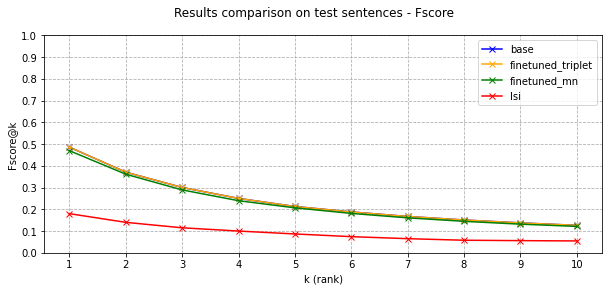

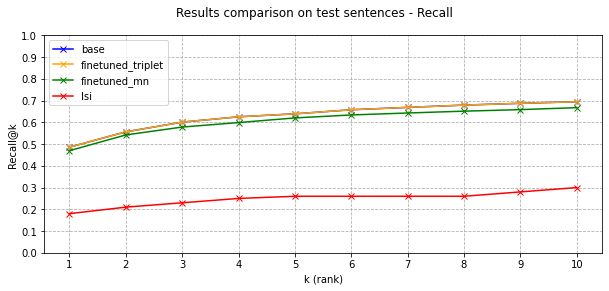

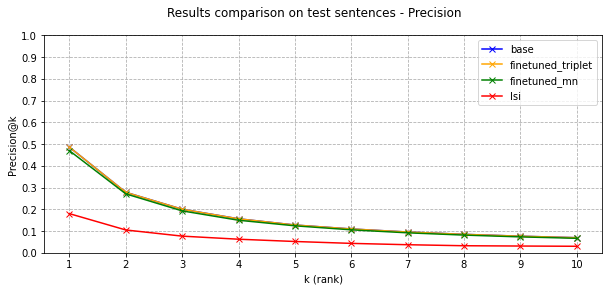

In [ ]:
title = "Results comparison on test sentences"
for index in results_test.index:
    print(f"Mean Average Precision for model {index}: {results_test['MAP'][index]:.3f}")
plot_metrics_multiple_models(results_test, title + " - Fscore", 'Fscore@k')
plot_metrics_multiple_models(results_test, title +" - Recall", 'Recall@k')
plot_metrics_multiple_models(results_test, title +" - Precision", 'Precision@k')

## Top2Vec topic mining

### Installs

In [ ]:
#!pip install top2vec
!pip install top2vec[sentence_encoders]

In [ ]:
from top2vec import Top2Vec

### Using top2vec tutorial

In [ ]:
documents = df_sorted['text'].values

In [ ]:
documents

In [ ]:
model = Top2Vec(documents, min_count=1, ngram_vocab=True, tokenizer=preprocess, embedding_model='universal-sentence-encoder', workers=100, speed='deep-learn')


In [ ]:
model.save('top2vec_model')

In [ ]:
model.load('top2vec_model')

In [ ]:
model.get_num_topics()

In [ ]:
model.get_topic_sizes()

In [ ]:
model.get_topics()

In [ ]:
model.query_documents('My name is jon arbuckle i am a cartoonist', num_docs=10)

In [ ]:
model.query_documents('I can''t sleep.', num_docs=10)

In [ ]:
#topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["monday", 'mondays'], num_topics=5)
#for topic in topic_nums:
#    model.generate_topic_wordcloud(topic)

## Text completion and generation


The hope is to train a generator model that can generate sentences to put in garfield strips.

Notable examples online are [Garkov](http://joshmillard.com/garkov/), GPT3, ecc.

IDK I am going to fine-tune a DistilRoberta to build a language model.

HOW TO EVALUATE during training: CROSS ENTROPY LOSS BASED ON TRAIN/VAL/SPLIT

MAKE A TRIGRAM MODEL ALSO (?)

FINAL TASK: 


test set: blanks the last phrase, the model predicts it. -> metric is the f1 based on the overlap between the prediction and the ground truth...

### Dataframe setup for sentence completion

We need to
- tokenize into a numerical format the bow.
- mask some parts for training our language model.

In [ ]:
# for training, discard rows that have empty strips.
df_gen = df_sorted[df_sorted['tokens'].map(len) > 0].copy().reset_index(drop=True)

# map text in dataframe to numerical indexes
df_gen['tokens_int'] = df_gen['tokens'].apply(lambda token_list: [dictionary.token2id[token] for token in token_list])

In [ ]:
df_gen

In [ ]:
TRY THIS

https://www.sbert.net/index.html

https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1))

In [ ]:
from gensim.models import FastText
import tensorflow as tf
import keras
from keras import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional

# prepare text for keras neural network

max_len = 30
sequence_docs = tf.keras.preprocessing.sequence.pad_sequences(df_gen['tokens_int'], maxlen=max_len, value=-1)

print(sequence_docs[0:10])

# define a keras model and load the pretrained fasttext weights matrix
model = Sequential()

inp = Input(shape=(max_len,1))
model.add(inp)

#model.add(Embedding(100, 10, input_length=max_len))

lstm_layer = LSTM(100, return_sequences=False, input_shape=(max_len,1))
model.add(lstm_layer)

#model.add(Dense(1))

model.build()
model.summary()

output = model.predict(sequence_docs)

In [ ]:
output.shape

In [ ]:
https://medium.com/analytics-vidhya/a-comprehensive-guide-to-build-your-own-language-model-in-python-5141b3917d6d